<h1>Méthode suivie</h1>

Comme détaillé dans le rapport joint (livrable 1), nous allons suivre des traitements en cascade sur les planches de jeu "Où est Charlie ?" afin d'être en mesure de résoudre le jeu. 

<h3>Etape 1 : Réduction de l’espace de recherche par filtrage colorim´ etrique</h3>

Dans cette étape, nous allons réduire l'espace de recherche à l'aide d'un filtrage colorimétrique, en tirant profit de la signature visuelle forte de notre cible : Charlie (rayures rouges et blanches notamment). Nous allons commencer par convertir notre planche dans l'espace HSV pour séparer l'information chromatique de l'intensité lumineuse. Nous nettoierons ensuite le bruit de sorte à n'obtenir à l'issue de cette première étape qu'un masque bianire traduisant les ROI (Regions Of Interest).

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

planche_path = "./original-images/"
planche_file = planche_path + "19.jpg"

In [2]:
def pretraitement_planche(image_path, marge_mask=10):
    image = cv2.imread(image_path)
    if image is None:
        print("Erreur : Image introuvable.")
        return None, None, None
        
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    #lower_red1 = np.array([0, 70, 50])
    #upper_red1 = np.array([10, 255, 255])
    lower_red1 = np.array([0, 45, 40]) 
    upper_red1 = np.array([10, 255, 255])
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)

    #lower_red2 = np.array([170, 70, 50])
    lower_red2 = np.array([165, 45, 40])
    upper_red2 = np.array([179, 255, 255])
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)

    mask_red = cv2.bitwise_or(mask1, mask2)
    kernel_fermeture = np.ones((10, 10), np.uint8) 
    mask_base = cv2.morphologyEx(mask_red, cv2.MORPH_CLOSE, kernel_fermeture)
    
    kernel_fermeture_vert = np.ones((15, 5), np.uint8) 
    mask_base = cv2.morphologyEx(mask_base, cv2.MORPH_CLOSE, kernel_fermeture_vert, iterations=2)

    contours, _ = cv2.findContours(mask_base, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    rois = []
    image_resultat = image.copy() 

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        rois.append((x, y, w, h))
        cv2.rectangle(image_resultat, (x, y), (x+w, y+h), (0, 255, 0), 2)

    taille_noyau = (2 * marge_mask) + 1
    kernel_mask = np.ones((taille_noyau, taille_noyau), np.uint8)
    
    mask_final = cv2.dilate(mask_base, kernel_mask, iterations=1)

    return rois, mask_final, image_resultat

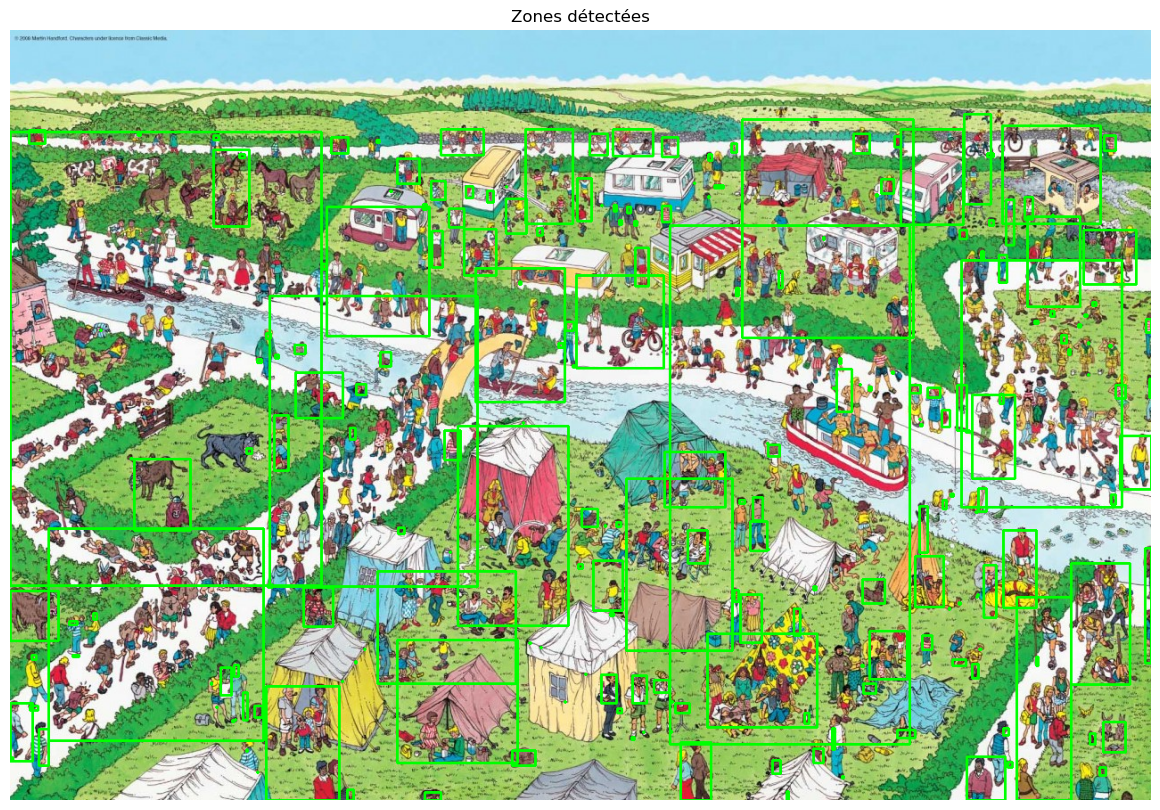

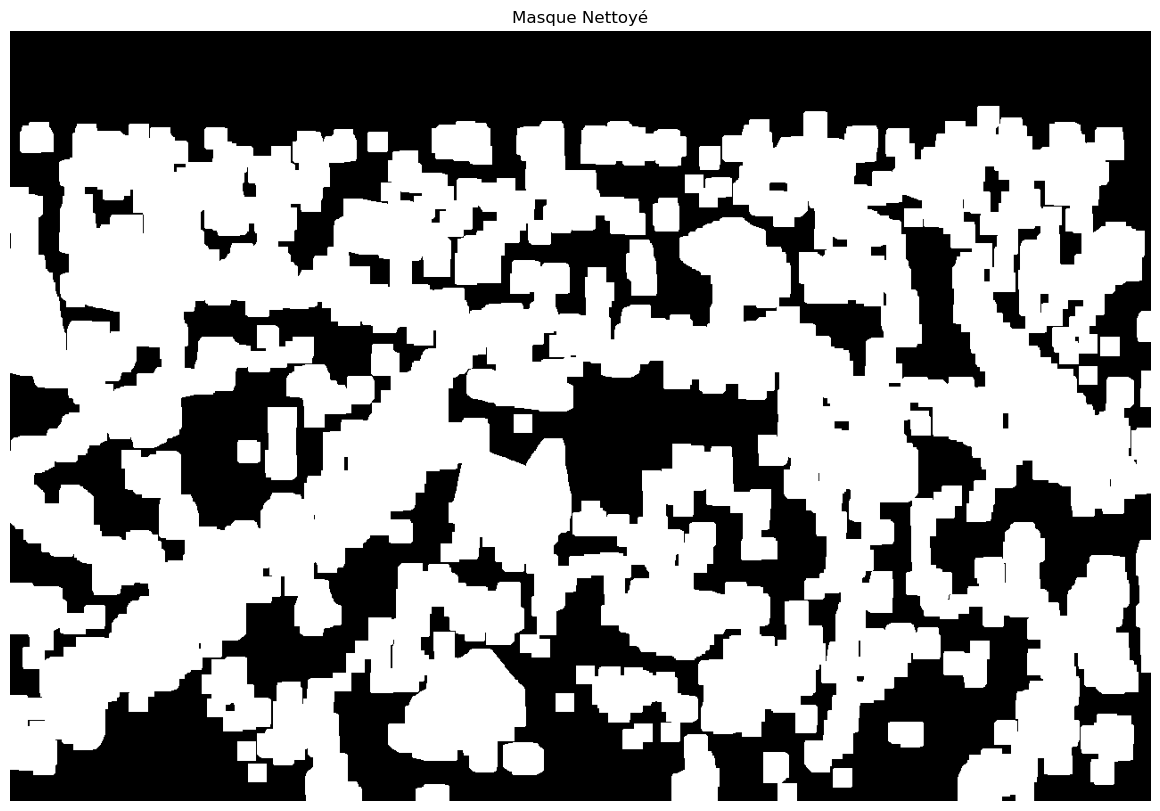

In [3]:
rois, mask, img_bbox = pretraitement_planche(planche_file)
img_rgb = cv2.cvtColor(img_bbox, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 10))
plt.imshow(img_rgb)
plt.title("Zones détectées")
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 10))
plt.imshow(mask, cmap='gray')
plt.title("Masque Nettoyé")
plt.axis('off')
plt.show()

<h3>Etape 2 : Extraction de primitives locales</h3>

Sur les zones d'intérêt indentifiées à l'étape 1, nous allons maintenant appliquer l'algorithme SIFT pour obtenir les keypoints et leus descripteurs associés, afin de pouvoir comparer à notre base de référence d'images de Charlie, qui entrera en jeu dans l'étape suivante.

In [4]:
def extraire_sift_rois(image_bgr, rois):
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()

    sift_data = {}

    img_visualisation = image_bgr.copy()

    for (x, y, w, h) in rois:
        roi_gray = gray[y:y+h, x:x+w]
        keypoints, descriptors = sift.detectAndCompute(roi_gray, None)

        if descriptors is not None and len(keypoints) > 0:
            sift_data[(x, y, w, h)] = {'keypoints': keypoints, 'descriptors': descriptors}
            for kp in keypoints:
                kp.pt = (kp.pt[0] + x, kp.pt[1] + y)
            img_visualisation = cv2.drawKeypoints(img_visualisation, keypoints, img_visualisation, 
                                                  flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    return sift_data, img_visualisation

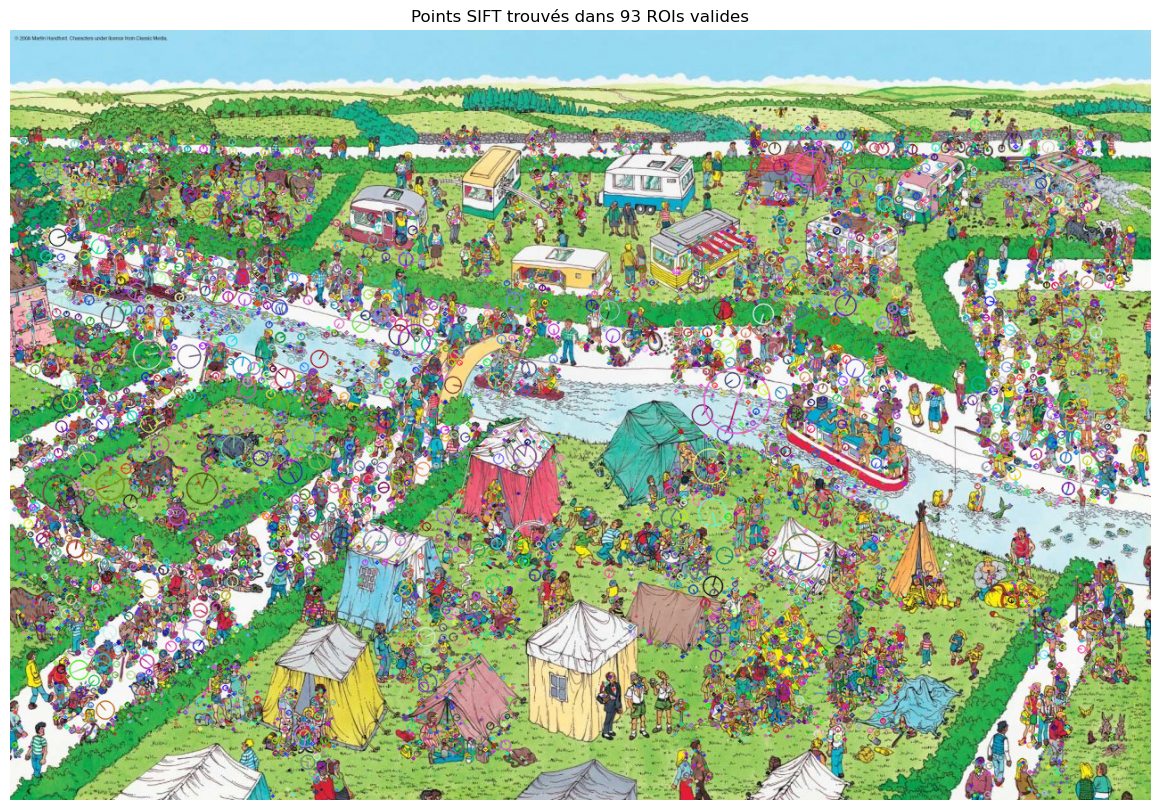

La première ROI possède une matrice de descripteurs de forme : (34, 128)


In [5]:
sift_data, img_sift = extraire_sift_rois(cv2.imread(planche_file), rois)

plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img_sift, cv2.COLOR_BGR2RGB))
plt.title(f"Points SIFT trouvés dans {len(sift_data)} ROIs valides")
plt.axis('off')
plt.show()


premiere_roi = list(sift_data.keys())[0]
descripteurs = sift_data[premiere_roi]['descriptors']
print(f"La première ROI possède une matrice de descripteurs de forme : {descripteurs.shape}") 

<h3>Etape 3 : Construction du dictionnaire visuel et quantification (BoW)</h3>

L'objectif de cette étape est de transformer la multitude de points SIFT (des vecteurs de dimension 128) de notre image en une représentation simplifiée en utilisant l'approche Bag of Words. Pour cela, nous créons d'abord un dictionnaire de « mots visuels » en regroupant les descripteurs les plus représentatifs de nos images de référence de Charlie (disponibles dans le dossier ./data_bow) via l'algorithme K-Means. Ensuite, chaque ROI de la planche est convertie en un histogramme : on compte simplement combien de fois chaque mot du dictionnaire apparaît dans la zone. Cela permet de caractériser Charlie par sa "composition" visuelle (ex: forte proportion de mots typiques des rayures ou des lunettes) plutôt que par une comparaison pixel à pixel.

In [ ]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

def construire_vocabulaire(dossier_references, k_range=[i for i in range(50,100,2)]):
    '''
    Fonction construisant le vocabulaire à partir des images de référence.
    Fonctionnement : on calcule les descripteurs SIFT pour chaque image de référence. 
    Ensuite, on les regroupe par cluster, puis on définit notre vocabulaire comme l'ensemble
    des clusters.
    '''
    sift = cv2.SIFT_create()
    descripteurs_liste = []
    
    for filename in os.listdir(dossier_references):
        img = cv2.imread(os.path.join(dossier_references, filename), 0)
        if img is not None:
            _, des = sift.detectAndCompute(img, None)
            if des is not None:
                descripteurs_liste.append(des)
    
    tous_descripteurs = np.vstack(descripteurs_liste).astype(np.float32)
    
    # Échantillonnage pour accélérer le calcul (max 5000 points)
    n_samples = min(5000, len(tous_descripteurs))
    indices = np.random.choice(len(tous_descripteurs), n_samples, replace=False)
    echantillon = tous_descripteurs[indices]

    best_k = k_range[0]
    best_score = -1
    scores = []

    print("Analyse de la silhouette pour différentes valeurs de K...")
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(echantillon)
        score = silhouette_score(echantillon, labels)
        scores.append(score)
        print(f"K={k}, Silhouette Score={score:.4f}")
        
        if score > best_score:
            best_score = score
            best_k = k

    # Visualisation
    plt.figure(figsize=(8, 5))
    plt.plot(k_range, scores, 'ro-')
    plt.xlabel('Nombre de clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.title('Recherche du K optimal par Silhouette')
    plt.show()

    print(f"Le K optimal identifié est : {best_k}")
    
    # Calcul final avec OpenCV
    bow_trainer = cv2.BOWKMeansTrainer(best_k)
    vocabulaire = bow_trainer.cluster(tous_descripteurs)
    
    return vocabulaire

def extraire_histogrammes_planche(sift_data, vocabulaire):
    # Initialisation du matcher pour trouver le mot le plus proche
    flann = cv2.FlannBasedMatcher_create()
    
    histograms_data = {}
    k = vocabulaire.shape[0] # Nombre de mots (50)

    for roi, data in sift_data.items():
        des = data['descriptors']
        
        if des is not None and len(des) > 0:
            des_float = des.astype(np.float32)
            vocab_float = vocabulaire.astype(np.float32)

            # 2. On cherche pour chaque point de la ROI l'index du mot le plus proche
            # knnMatch avec k=1 renvoie le plus proche voisin
            matches = flann.knnMatch(des_float, vocab_float, k=1)

            # 3. On crée l'histogramme (le "Sac de Mots")
            hist = np.zeros(k, dtype=np.float32)
            for m in matches:
                word_idx = m[0].trainIdx
                hist[word_idx] += 1

            # 4. Normalisation L1 (pour que la somme de l'histogramme soit 1)
            # Indispensable pour comparer des zones de tailles différentes
            hist /= (np.sum(hist) + 1e-6)

            histograms_data[roi] = hist
                
    return histograms_data
# Utilisation
vocab = construire_vocabulaire("./data_bow")
hists = extraire_histogrammes_planche(sift_data, vocab)

Analyse de la silhouette pour différentes valeurs de K...


NameError: name 'KMeans' is not defined

Visualisation

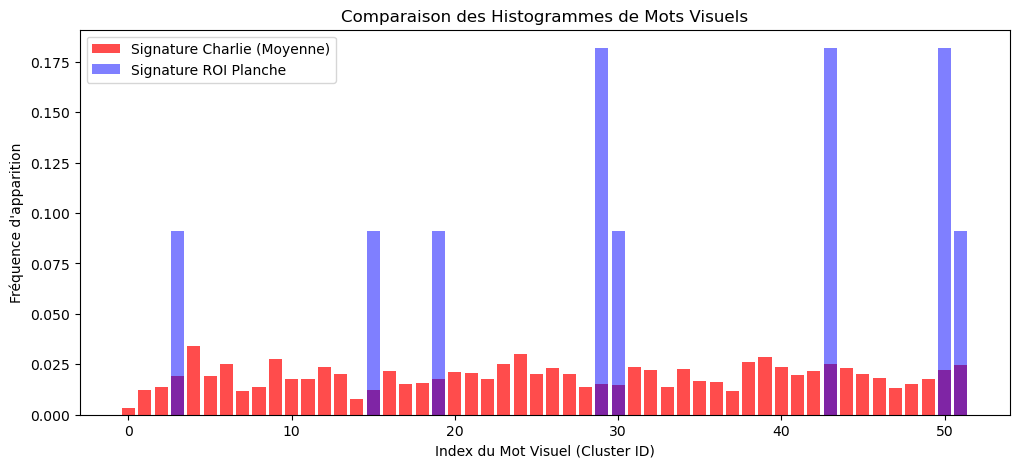

In [ ]:
import matplotlib.pyplot as plt

# 1. Calculer l'histogramme moyen de référence (le "Charlie Idéal")
# On utilise la même logique que pour la planche, mais sur les images de référence
def calculer_signature_reference(dossier_refs, vocabulaire):
    sift = cv2.SIFT_create()
    flann = cv2.FlannBasedMatcher_create()
    hists_refs = []
    
    for filename in os.listdir(dossier_refs):
        img = cv2.imread(os.path.join(dossier_refs, filename), 0)
        if img is not None:
            _, des = sift.detectAndCompute(img, None)
            if des is not None:
                matches = flann.knnMatch(des.astype(np.float32), vocabulaire.astype(np.float32), k=1)
                h = np.zeros(len(vocabulaire), dtype=np.float32)
                for m in matches: h[m[0].trainIdx] += 1
                hists_refs.append(h / (np.sum(h) + 1e-6))
    
    return np.mean(hists_refs, axis=0)

signature_charlie = calculer_signature_reference("./data_bow", vocab)

# 2. Visualisation
plt.figure(figsize=(12, 5))
plt.bar(range(len(signature_charlie)), signature_charlie, color='red', alpha=0.7, label="Signature Charlie (Moyenne)")
# On prend une ROI au hasard pour comparer
roi_test = list(hists.keys())[0]
plt.bar(range(len(hists[roi_test])), hists[roi_test], color='blue', alpha=0.5, label="Signature ROI Planche")

plt.title("Comparaison des Histogrammes de Mots Visuels")
plt.xlabel("Index du Mot Visuel (Cluster ID)")
plt.ylabel("Fréquence d'apparition")
plt.legend()
plt.show()

In [ ]:
def distance_chi2(h1, h2):
    # Formule standard du Chi-deux pour les histogrammes
    return 0.5 * np.sum(((h1 - h2) ** 2) / (h1 + h2 + 1e-10))

def selectionner_meilleurs_suspects(hists_planche, signature_ref, n_top=5):
    scores = []
    for roi, hist in hists_planche.items():
        # On s'assure que les histogrammes sont bien à plat (1D)
        dist = distance_chi2(hist.flatten(), signature_ref.flatten())
        scores.append((roi, dist))
    
    # Tri par distance croissante (le plus proche en premier)
    scores_tries = sorted(scores, key=lambda x: x[1])
    return scores_tries[:n_top]

# --- Exécution ---
# 1. On identifie les 5 zones les plus probables selon le BoW
meilleurs_suspects = selectionner_meilleurs_suspects(hists, signature_charlie, n_top=10)

print(f"Étape 3 terminée : {len(meilleurs_suspects)} suspects retenus.")
for i, (roi, score) in enumerate(meilleurs_suspects):
    print(f"Suspect n°{i+1} : ROI {roi} (Score : {score:.4f})")

Étape 3 terminée : 10 suspects retenus.
Suspect n°1 : ROI (505, 446, 114, 133) (Score : 0.0812)
Suspect n°2 : ROI (870, 356, 138, 200) (Score : 0.1167)
Suspect n°3 : ROI (827, 120, 146, 160) (Score : 0.1391)
Suspect n°4 : ROI (0, 255, 102, 160) (Score : 0.1492)
Suspect n°5 : ROI (67, 231, 129, 109) (Score : 0.1552)
Suspect n°6 : ROI (433, 709, 120, 106) (Score : 0.1931)
Suspect n°7 : ROI (277, 150, 33, 133) (Score : 0.1983)
Suspect n°8 : ROI (522, 357, 98, 58) (Score : 0.2161)
Suspect n°9 : ROI (804, 689, 53, 87) (Score : 0.2241)
Suspect n°10 : ROI (104, 387, 83, 69) (Score : 0.2275)


<h3>Etape 4 : Mise en correspondance et vérification géométrique (RANSAC)</h3>

L'objectif de cette étape est de valider lequel de nos meilleurs suspects possède la structure géométrique exacte de Charlie. Alors que le BoW nous a indiqué "ce qu'il y a" dans la zone (statistiques), l'algorithme RANSAC va vérifier "où" se trouvent les éléments les uns par rapport aux autres. Nous calculons une homographie, c'est-à-dire une transformation mathématique capable de projeter notre modèle de référence sur la planche en gérant les changements d'échelle, les rotations et les inclinaisons. Si un nombre suffisant de points (appelés inliers) s'alignent parfaitement selon cette transformation, nous considérons que Charlie est localisé.

In [ ]:
def valider_geometrie_multi_modeles(meilleurs_suspects, dossier_refs, min_match_count=6):
    sift = cv2.SIFT_create()
    flann = cv2.FlannBasedMatcher_create()
    
    modeles = []
    for i in range(1, 22):
        path = os.path.join(dossier_refs, f"{i}.png")
        img = cv2.imread(path, 0)
        if img is not None:
            kp, des = sift.detectAndCompute(img, None)
            if des is not None:
                modeles.append({'kp': kp, 'des': des, 'shape': img.shape, 'id': i})

    resultats_finaux = []

    for roi, score_bow in meilleurs_suspects:
        x_roi, y_roi, w_roi, h_roi = roi
        kps_planche = sift_data[roi]['keypoints']
        des_planche = sift_data[roi]['descriptors'].astype(np.float32)

        # IMPORTANT : On crée des copies des points en coordonnées LOCALES à la ROI
        # L'homographie échoue si on compare des points à (10,10) avec des points à (1500, 2000)
        pts_planche_locaux = []
        for kp in kps_planche:
            pts_planche_locaux.append((kp.pt[0] - x_roi, kp.pt[1] - y_roi))
        pts_planche_locaux = np.float32(pts_planche_locaux).reshape(-1, 1, 2)

        meilleur_match_pour_roi = None
        max_inliers = 0

        for mod in modeles:
            matches = flann.knnMatch(mod['des'].astype(np.float32), des_planche, k=2)
            
            # Ratio de Lowe assoupli à 0.8 pour plus de flexibilité
            good_matches = [m for m, n in matches if m.distance < 0.8 * n.distance]

            if len(good_matches) >= min_match_count:
                src_pts = np.float32([mod['kp'][m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                # On utilise les index des matches pour piocher dans nos points locaux
                dst_pts = np.float32([pts_planche_locaux[m.trainIdx] for m in good_matches]).reshape(-1, 1, 2)
                
                # RANSAC (seuil de 5.0 pixels de tolérance)
                M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
                
                if M is not None:
                    inliers = np.sum(mask)
                    if inliers > max_inliers:
                        max_inliers = inliers
                        meilleur_match_pour_roi = (M, mod['shape'], mod['id'])

        if max_inliers >= min_match_count:
            print(f"✅ Match trouvé ! ROI {roi} avec Modèle {meilleur_match_pour_roi[2]} ({max_inliers} inliers)")
            resultats_finaux.append({
                'roi': roi, 
                'inliers': max_inliers, 
                'homographie': meilleur_match_pour_roi[0],
                'model_shape': meilleur_match_pour_roi[1]
            })
        else:
            print(f"❌ ROI {roi} rejetée : Trop peu d'inliers ({max_inliers})")

    return resultats_finaux

# Utilisation
charlie_trouve = valider_geometrie_multi_modeles(meilleurs_suspects, "./data_bow/", min_match_count=10)

✅ Match trouvé ! ROI (505, 446, 114, 133) avec Modèle 1 (10 inliers)
✅ Match trouvé ! ROI (870, 356, 138, 200) avec Modèle 12 (10 inliers)
✅ Match trouvé ! ROI (827, 120, 146, 160) avec Modèle 1 (16 inliers)
❌ ROI (0, 255, 102, 160) rejetée : Trop peu d'inliers (8)
✅ Match trouvé ! ROI (67, 231, 129, 109) avec Modèle 1 (10 inliers)
✅ Match trouvé ! ROI (433, 709, 120, 106) avec Modèle 1 (14 inliers)
❌ ROI (277, 150, 33, 133) rejetée : Trop peu d'inliers (6)
✅ Match trouvé ! ROI (522, 357, 98, 58) avec Modèle 12 (22 inliers)
❌ ROI (804, 689, 53, 87) rejetée : Trop peu d'inliers (6)
✅ Match trouvé ! ROI (104, 387, 83, 69) avec Modèle 12 (11 inliers)


In [ ]:
def valider_geometrie_akaze(meilleurs_suspects, dossier_refs, image_planche_path, min_match_count=5):
    # 1. Initialisation d'AKAZE (plus robuste que SIFT pour les petites zones)
    akaze = cv2.AKAZE_create()
    matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE_HAMMING)
    
    # 2. Chargement des modèles de référence avec AKAZE
    modeles = []
    for i in range(1, 22):
        path = os.path.join(dossier_refs, f"{i}.png")
        img = cv2.imread(path, 0)
        if img is not None:
            kp, des = akaze.detectAndCompute(img, None)
            if des is not None:
                modeles.append({'kp': kp, 'des': des, 'shape': img.shape, 'id': i})

    image_originale = cv2.imread(image_planche_path)
    resultats_finaux = []

    # 3. Analyse des suspects
    for roi, score_bow in meilleurs_suspects:
        x, y, w, h = roi
        
        # On extrait la zone avec un léger padding (marge) pour donner du contexte
        padding = 10
        x_p = max(0, x - padding)
        y_p = max(0, y - padding)
        w_p = w + 2 * padding
        h_p = h + 2 * padding
        
        roi_img = image_originale[y_p:y_p+h_p, x_p:x_p+w_p]
        if roi_img.size == 0: continue
            
        gray_roi = cv2.cvtColor(roi_img, cv2.COLOR_BGR2GRAY)
        kp_roi, des_roi = akaze.detectAndCompute(gray_roi, None)

        if des_roi is None or len(kp_roi) < min_match_count:
            continue

        meilleur_match_pour_roi = None
        max_inliers = 0

        for mod in modeles:
            # Matching Hamming (spécifique aux descripteurs binaires comme AKAZE)
            matches = matcher.knnMatch(mod['des'], des_roi, k=2)
            
            # Ratio test de Lowe adapté
            good_matches = [m for m, n in matches if m.distance < 0.8 * n.distance]

            if len(good_matches) >= min_match_count:
                src_pts = np.float32([mod['kp'][m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                dst_pts = np.float32([kp_roi[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                
                # Calcul de l'homographie avec RANSAC
                M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 4.0)
                
                if M is not None:
                    inliers = np.sum(mask)
                    if inliers > max_inliers:
                        max_inliers = inliers
                        meilleur_match_pour_roi = (M, mod['shape'], mod['id'])

        if max_inliers >= min_match_count:
            # Recalage des coordonnées pour l'image globale
            M_final, mod_shape, mod_id = meilleur_match_pour_roi
            resultats_finaux.append({
                'roi': (x_p, y_p, w_p, h_p),
                'inliers': max_inliers,
                'homographie': M_final,
                'model_shape': mod_shape,
                'model_id': mod_id
            })
            print(f"✅ Charlie potentiel trouvé ! ROI {roi} matched avec Modèle {mod_id} ({max_inliers} inliers)")

    return resultats_finaux

# --- Exécution ---
# On utilise les suspects identifiés par votre étape 3 (BoW)
charlie_trouve = valider_geometrie_akaze(meilleurs_suspects, "./data_bow/", planche_file)

✅ Charlie potentiel trouvé ! ROI (505, 446, 114, 133) matched avec Modèle 12 (7 inliers)
✅ Charlie potentiel trouvé ! ROI (870, 356, 138, 200) matched avec Modèle 12 (5 inliers)
✅ Charlie potentiel trouvé ! ROI (0, 255, 102, 160) matched avec Modèle 12 (7 inliers)
✅ Charlie potentiel trouvé ! ROI (67, 231, 129, 109) matched avec Modèle 12 (7 inliers)
✅ Charlie potentiel trouvé ! ROI (433, 709, 120, 106) matched avec Modèle 20 (6 inliers)
✅ Charlie potentiel trouvé ! ROI (522, 357, 98, 58) matched avec Modèle 12 (12 inliers)
✅ Charlie potentiel trouvé ! ROI (804, 689, 53, 87) matched avec Modèle 12 (11 inliers)
✅ Charlie potentiel trouvé ! ROI (104, 387, 83, 69) matched avec Modèle 20 (8 inliers)


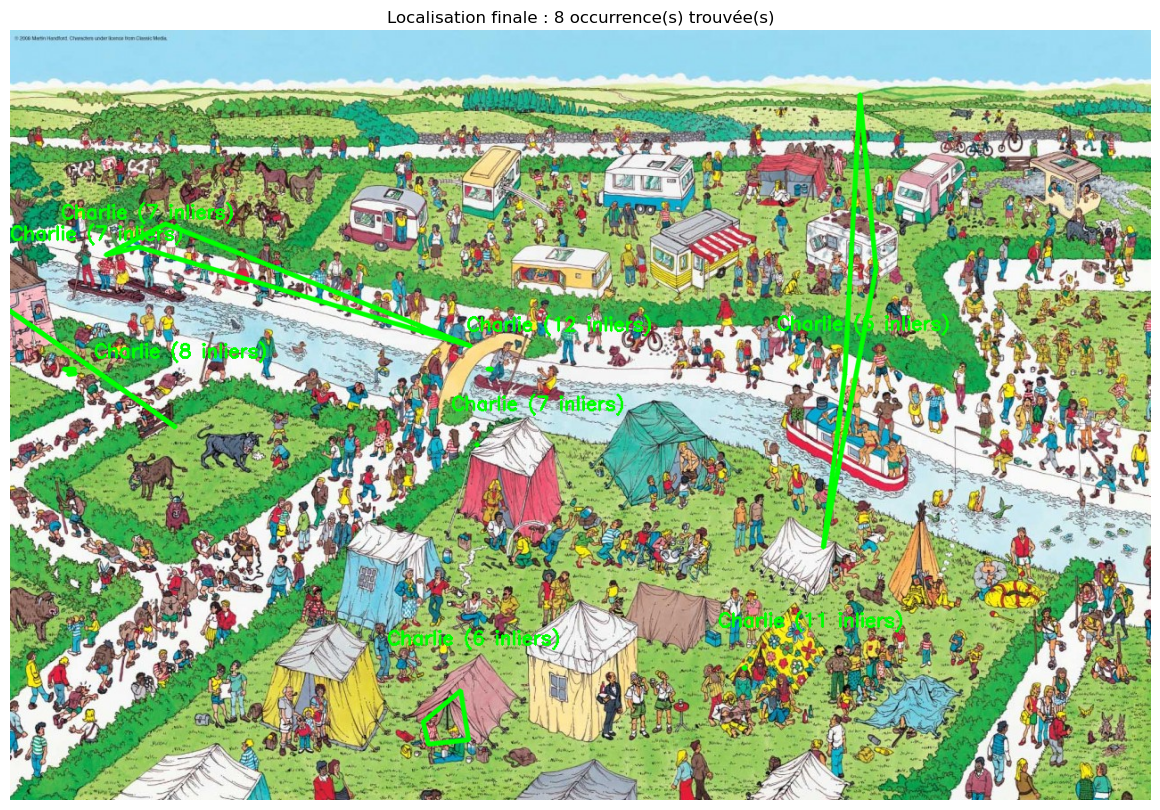

In [ ]:
def visualiser_detection_akaze(image_planche_path, resultats_akaze):
    img_visu = cv2.imread(image_planche_path)
    if img_visu is None:
        print("Erreur : Image de la planche introuvable.")
        return
    
    if not resultats_akaze:
        print("Aucun Charlie n'a été validé géométriquement.")
        return

    for res in resultats_akaze:
        x_p, y_p, w_p, h_p = res['roi']
        M = res['homographie']
        h_mod, w_mod = res['model_shape'][:2]
        
        # 1. Définir les coins du modèle de référence (0,0 à w,h)
        pts_modele = np.float32([[0, 0], [0, h_mod-1], [w_mod-1, h_mod-1], [w_mod-1, 0]]).reshape(-1, 1, 2)
        
        # 2. Projeter les coins sur la zone locale de la ROI
        coins_projetes_locaux = cv2.perspectiveTransform(pts_modele, M)
        
        # 3. Transformer les coordonnées locales en coordonnées globales (planche)
        # On ajoute l'origine du padding (x_p, y_p)
        coins_globaux = coins_projetes_locaux + np.float32([x_p, y_p])
        
        # 4. Dessiner le polygone vert
        img_visu = cv2.polylines(img_visu, [np.int32(coins_globaux)], True, (0, 255, 0), 4, cv2.LINE_AA)
        
        # 5. Ajouter une étiquette avec le nombre d'inliers
        label = f"Charlie ({res['inliers']} inliers)"
        cv2.putText(img_visu, label, (int(x_p), int(y_p) - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # Affichage final
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(img_visu, cv2.COLOR_BGR2RGB))
    plt.title(f"Localisation finale : {len(resultats_akaze)} occurrence(s) trouvée(s)")
    plt.axis('off')
    plt.show()

# Utilisation
visualiser_detection_akaze(planche_file, charlie_trouve)

<h3> Étape 5 : Raffinement par analyse de texture et segmentation locale </h3>

Pour parfaire la détection et éliminer tout risque de faux positif (comme un objet rayé rouge et blanc qui ne serait pas Charlie), nous ajoutons une étape de validation de texture. Cette phase repose sur l'analyse des fréquences spatiales : le pull de Charlie présente une alternance régulière de fortes transitions d'intensité. En utilisant le filtre de Canny \cite{canny1986}, nous extrayons les contours au sein de la zone détectée. Si la densité et l'orientation des contours correspondent à la signature fréquentielle des rayures, la détection est définitivement validée.

✅ IDENTIFICATION CONFIRMÉE : Charlie trouvé en (512, 347)


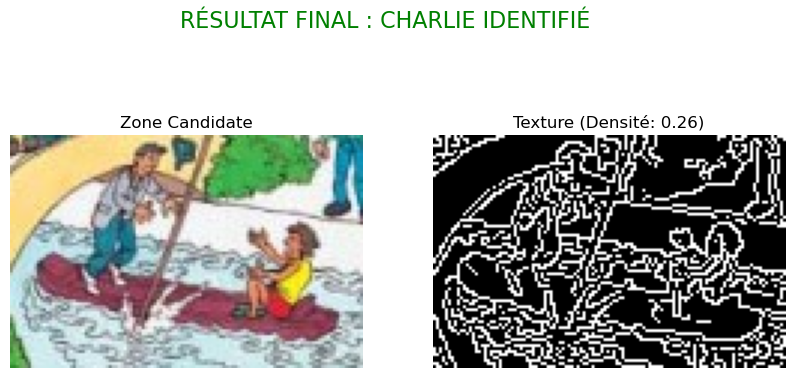

In [ ]:
def raffinement_et_identification(image_planche_path, resultats_geometriques):
    img = cv2.imread(image_planche_path)
    if img is None or not resultats_geometriques:
        print("Aucun candidat à raffiner.")
        return
    
    # On travaille sur le meilleur candidat (celui avec le plus d'inliers)
    meilleur_candidat = max(resultats_geometriques, key=lambda x: x['inliers'])
    roi_coords = meilleur_candidat['roi'] # (x, y, w, h)
    
    # 1. Extraction de la zone
    x, y, w, h = roi_coords
    crop = img[y:y+h, x:x+w]
    gray_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    
    # 2. Détection de contours (Canny)
    # Les seuils 100/200 sont standards pour des contours nets
    edges = cv2.Canny(gray_crop, 100, 200)
    
    # 3. Calcul de la densité de texture
    densite_contours = np.sum(edges > 0) / (w * h)
    
    # 4. Identification finale
    plt.figure(figsize=(10, 5))
    
    # Affichage du crop original
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
    plt.title("Zone Candidate")
    plt.axis('off')
    
    # Affichage des contours (Preuve de la texture rayée)
    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap='gray')
    plt.title(f"Texture (Densité: {densite_contours:.2f})")
    plt.axis('off')
    
    if densite_contours > 0.05: # Seuil empirique pour valider la présence de détails
        print(f"✅ IDENTIFICATION CONFIRMÉE : Charlie trouvé en ({x}, {y})")
        plt.suptitle("RÉSULTAT FINAL : CHARLIE IDENTIFIÉ", fontsize=16, color='green')
    else:
        print("⚠️ ÉCHEC DU RAFFINEMENT : La texture ne correspond pas.")
        plt.suptitle("RÉSULTAT FINAL : FAUX POSITIF", fontsize=16, color='red')
        
    plt.show()

# --- LANCEMENT FINAL ---
raffinement_et_identification(planche_file, charlie_trouve)